In [2]:
#import packages
import numpy as np # linear algebra
print(np.__version__)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import SimpleRNN
from keras.layers import LSTM

1.19.5


(4100, 10) (3690, 1) (410, 1)


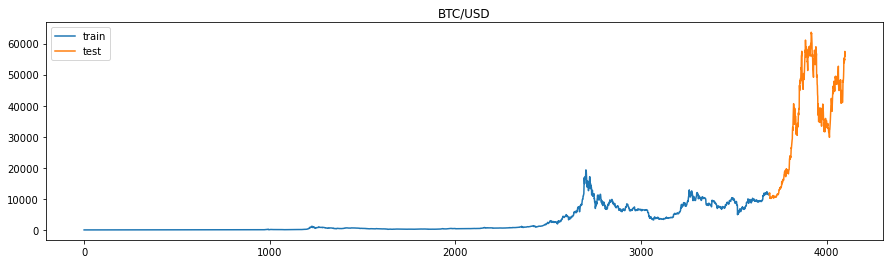

In [22]:

#data read
df=pd.read_csv("./BNC_BLX, D.csv", parse_dates=['time'])
df.head()
ratioOfFit = 0.9
train = np.array(df.iloc[:int(ratioOfFit*len(df)), 1:2])
test = np.array(df.iloc[int(ratioOfFit*len(df)):, 1:2])
print(df.shape, train.shape, test.shape)
df['open'][:int(ratioOfFit*len(df))].plot(figsize=(15,4), legend=True)
df['open'][int(ratioOfFit*len(df)):].plot(figsize=(15,4), legend=True)
plt.legend(['train', 'test'])
plt.title('BTC/USD')
plt.show()

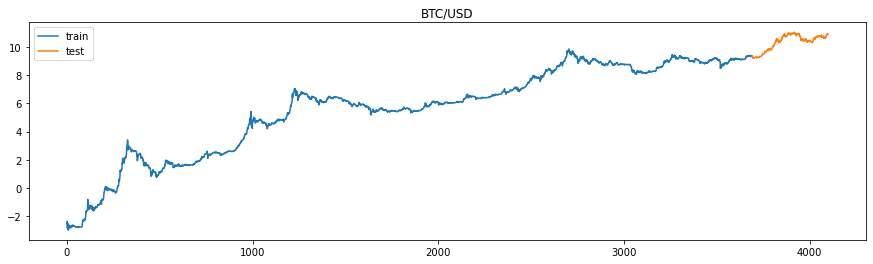

In [23]:
#data processing
train=np.log(train)
test=np.log(test)
np.log(df['open'][:int(ratioOfFit*len(df))]).plot(figsize=(15,4), legend=True)
np.log(df['open'][int(ratioOfFit*len(df)):]).plot(figsize=(15,4), legend=True)
plt.legend(['train', 'test'])
plt.title('BTC/USD')
plt.show()

In [46]:
train = np.array(train)

input_buffer = 300
output_buffer = 30
n_epochs = 3
n_batch = 5


#input_buffer size에 맞게 x_train set 만들기
x_train = []
for i in range(train.size-input_buffer-output_buffer):
    x_train.append([])
    for j in range(input_buffer):
        x_train[-1].append(train[i+j,0])
x_train=np.array(x_train)
print(x_train.shape)

#output_buffer size에 맞게 y_train set 만들기
train = np.array(train)
y_train = []
for i in range(input_buffer, train.size-output_buffer):
    y_train.append([])
    for j in range(output_buffer):
        y_train[-1].append(train[i+j,0])
y_train=np.array(y_train)
print(y_train.shape)

(3360, 300)
(3360, 30)


In [47]:
#rnn 모델생성
layer_input = keras.Input(shape=(input_buffer,1), name='input')
layer_rnn = keras.layers.SimpleRNN(100, activation='tanh', name='RNN')(layer_input)
layer_output = keras.layers.Dense(output_buffer, name='output')(layer_rnn)
rnn = keras.Model(layer_input, layer_output)
print(rnn.summary())
rnn.compile(loss = 'mse', optimizer='adam')
#fitting 후 결과 확인
rnn.fit(x_train, y_train, epochs=n_epochs, batch_size=n_batch)
print(y_train.shape)
print(rnn.predict(x_train).shape)

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 300, 1)]          0         
_________________________________________________________________
RNN (SimpleRNN)              (None, 100)               10200     
_________________________________________________________________
output (Dense)               (None, 30)                3030      
Total params: 13,230
Trainable params: 13,230
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
672/672 [==============================] - 14s 20ms/step - loss: 2.0739
Epoch 2/3
672/672 [==============================] - 13s 19ms/step - loss: 0.0584
Epoch 3/3
672/672 [==============================] - 13s 19ms/step - loss: 0.0576
(3360, 30)
(3360, 30)


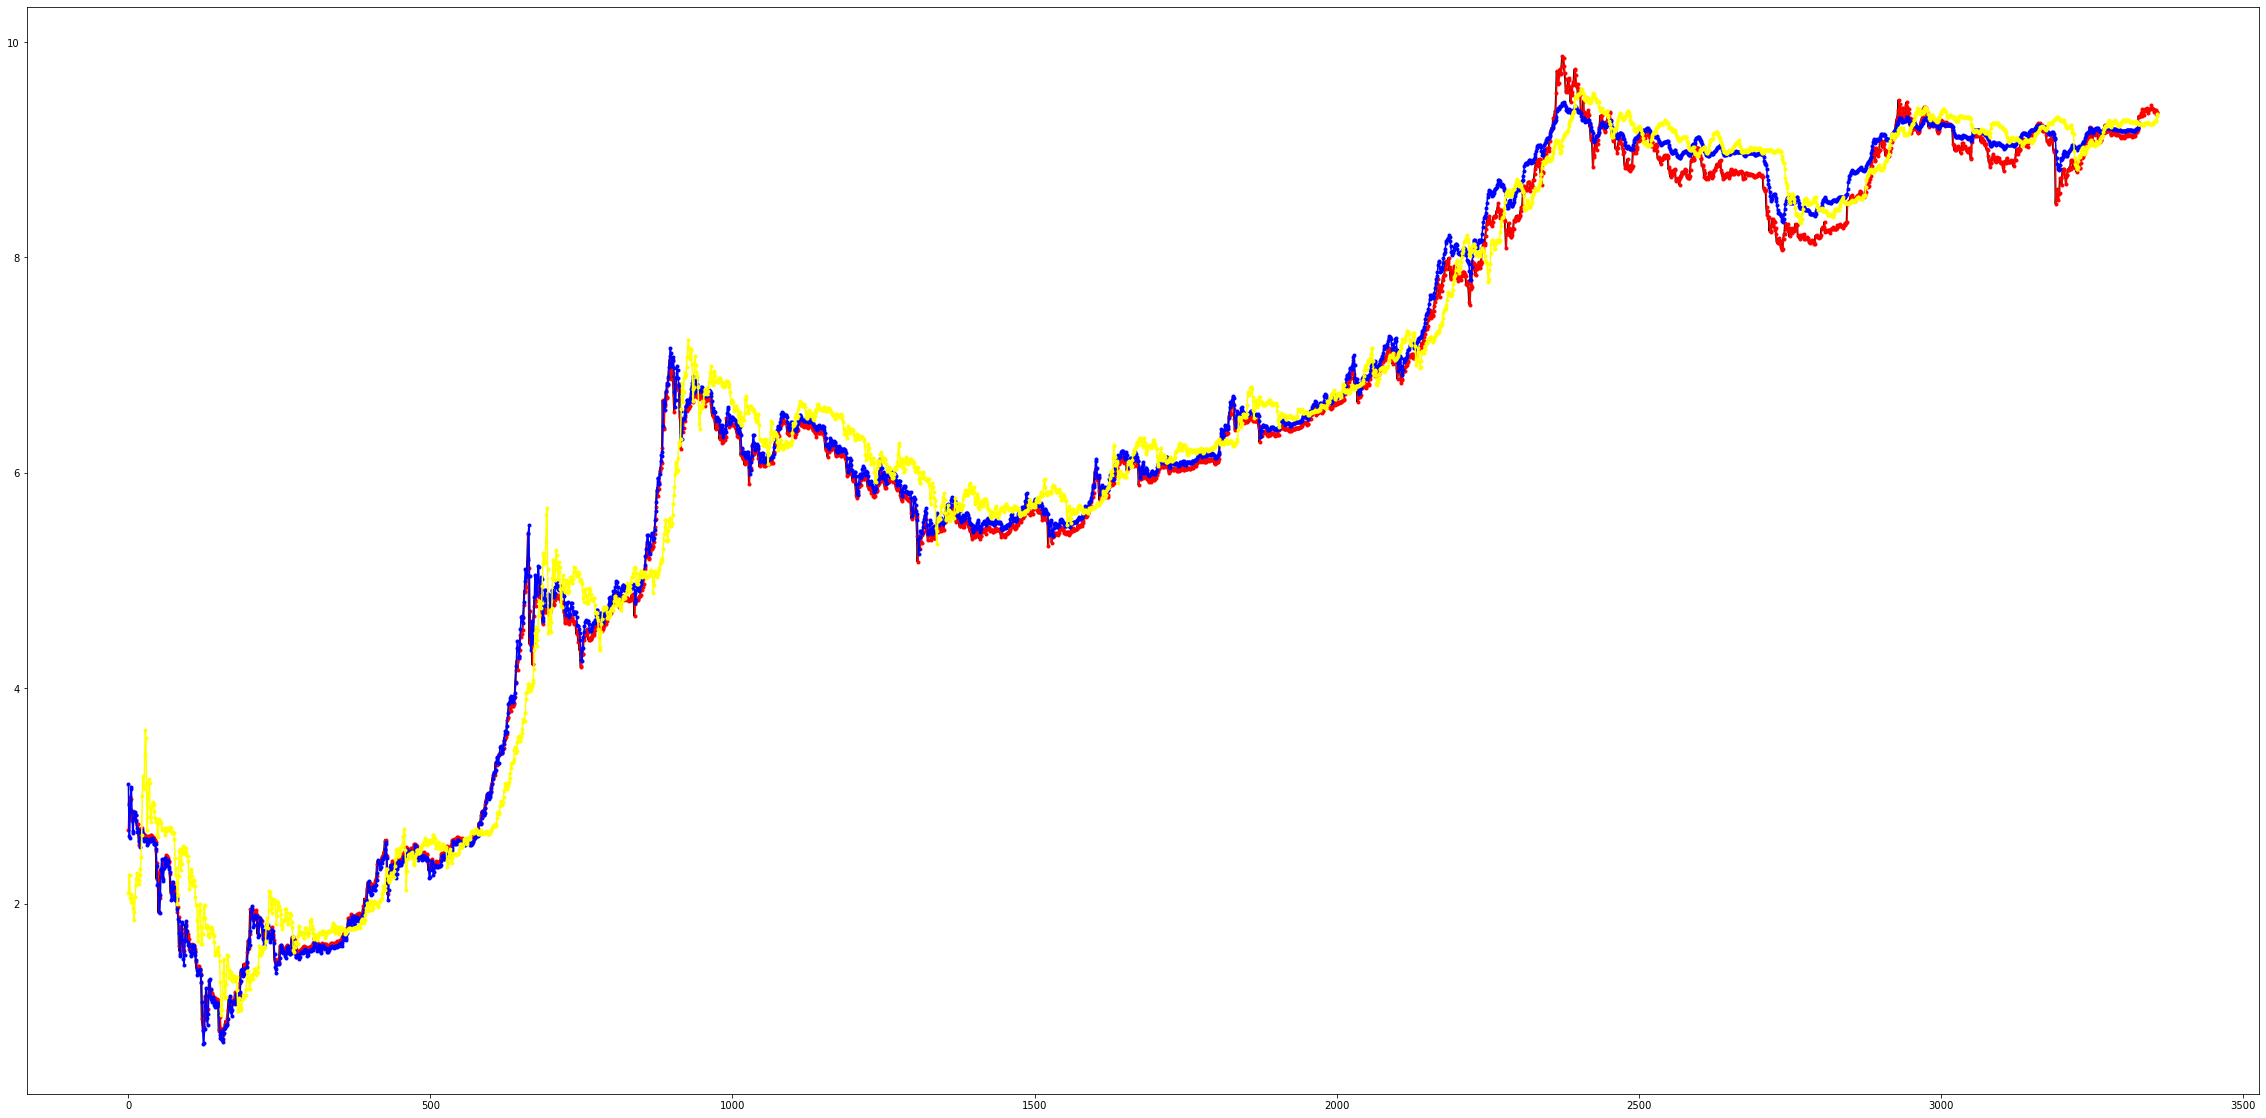

In [48]:
#rnn trainning result
plt.figure(figsize=(40,20))
plt.plot(y_train[output_buffer:,0], marker=',', label='real',  color='black')
plt.plot(y_train[:,-1], marker='.', label='real',  color='red')
plt.plot(rnn.predict(x_train)[output_buffer:,0], marker='.', label='RNN',  color='blue')
plt.plot(rnn.predict(x_train)[:,-1], marker='.', label='RNN',  color='yellow')
plt.show()

In [49]:
#lstm 모델생성
layer_input = keras.Input(shape=(input_buffer,1), name='input')
layer_lstm = keras.layers.LSTM(200, activation='tanh', name='LSTM')(layer_input)
layer_output = keras.layers.Dense(output_buffer, name='output')(layer_lstm)
lstm = keras.Model(layer_input, layer_output)
print(lstm.summary())
lstm.compile(loss = 'mse', optimizer='adam')
#fitting 후 결과 확인
lstm.fit(x_train, y_train, epochs=n_epochs, batch_size=n_batch)
print(x_train.shape)
print(lstm.predict(x_train).shape)

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 300, 1)]          0         
_________________________________________________________________
LSTM (LSTM)                  (None, 200)               161600    
_________________________________________________________________
output (Dense)               (None, 30)                6030      
Total params: 167,630
Trainable params: 167,630
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
672/672 [==============================] - 47s 70ms/step - loss: 2.4233
Epoch 2/3
672/672 [==============================] - 47s 70ms/step - loss: 0.0678
Epoch 3/3
672/672 [==============================] - 48s 72ms/step - loss: 0.0614
(3360, 300)
[[1.788004  1.7229481 1.6760325 ... 1.8435718 1.8607342 1.8661821]
 [1.9549825 1.8808299 1.8261915 ... 2.0186596 2

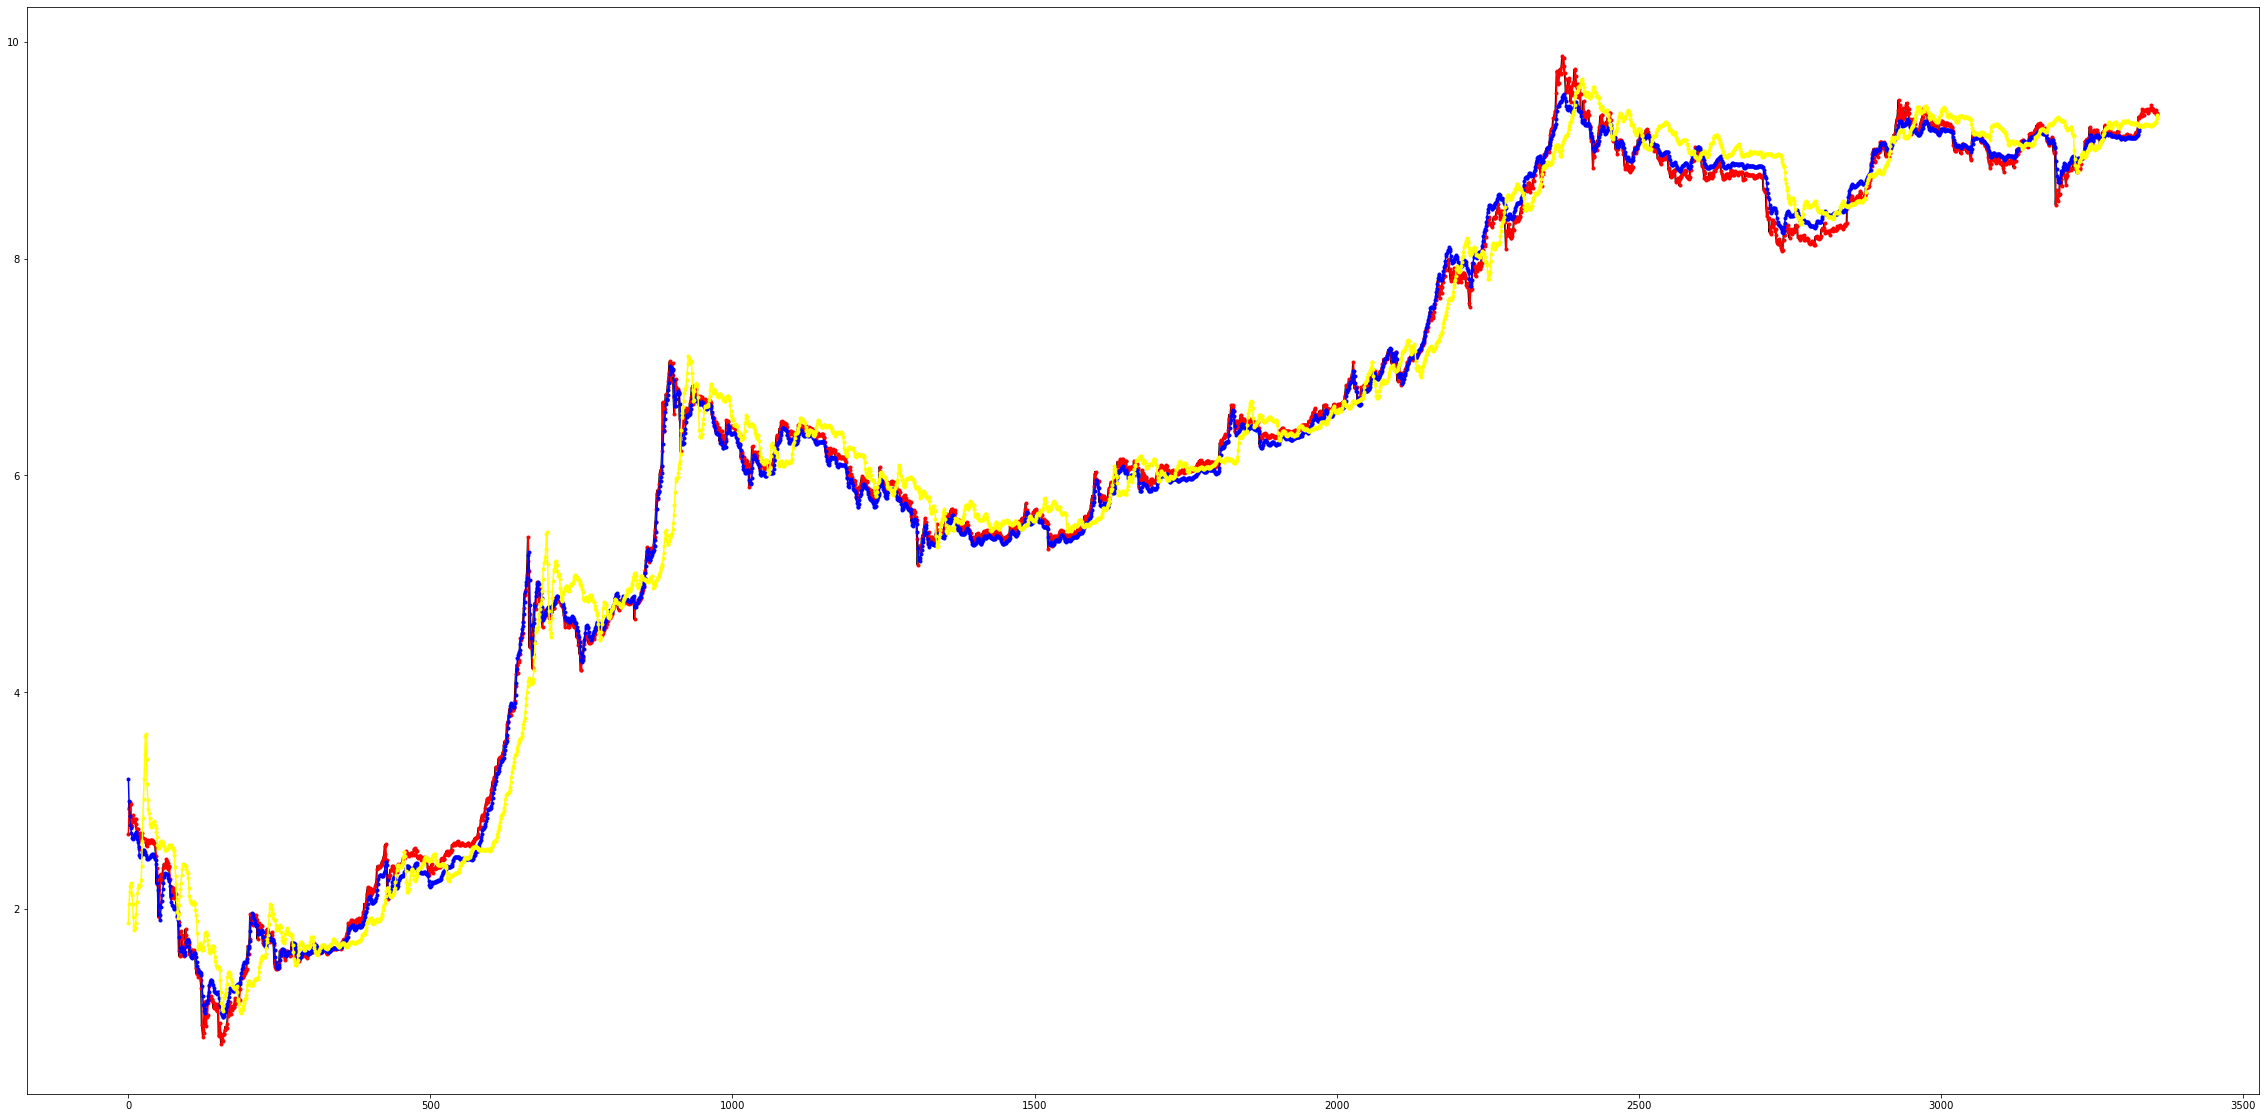

In [50]:
#lstm trainning result
plt.figure(figsize=(40,20))
plt.plot(y_train[output_buffer:,0], marker=',', label='real',  color='black')
plt.plot(y_train[:,-1], marker='.', label='real',  color='red')
plt.plot(lstm.predict(x_train)[output_buffer:,0], marker='.', label='lstm',  color='blue')
plt.plot(lstm.predict(x_train)[:,-1], marker='.', label='lstm',  color='yellow')
plt.show()

In [58]:
#rnn prediction(rnn.predict()[,0] add to real data)
predict_rnn = train
for _ in range(int((1-ratioOfFit)*len(df))):
    temp = []
    temp.append([])
    for i in range(len(predict_rnn)-input_buffer, len(predict_rnn)):
        temp[-1].append(predict_rnn[i][0])
    temp = np.array(temp)
    predict_rnn = np.append(predict_rnn, [rnn.predict(temp)[:,0]], axis=0)

In [57]:

#lstm prediction(lstm.predict()[,0] add to real data)
predict_lstm = train
for _ in range(int((1-ratioOfFit)*len(df))):
    temp = []
    temp.append([])
    for i in range(len(predict_lstm)-input_buffer, len(predict_lstm)):
        temp[-1].append(predict_lstm[i][0])
    temp = np.array(temp)
    predict_lstm = np.append(predict_lstm, [lstm.predict(temp)[:,0]], axis=0)

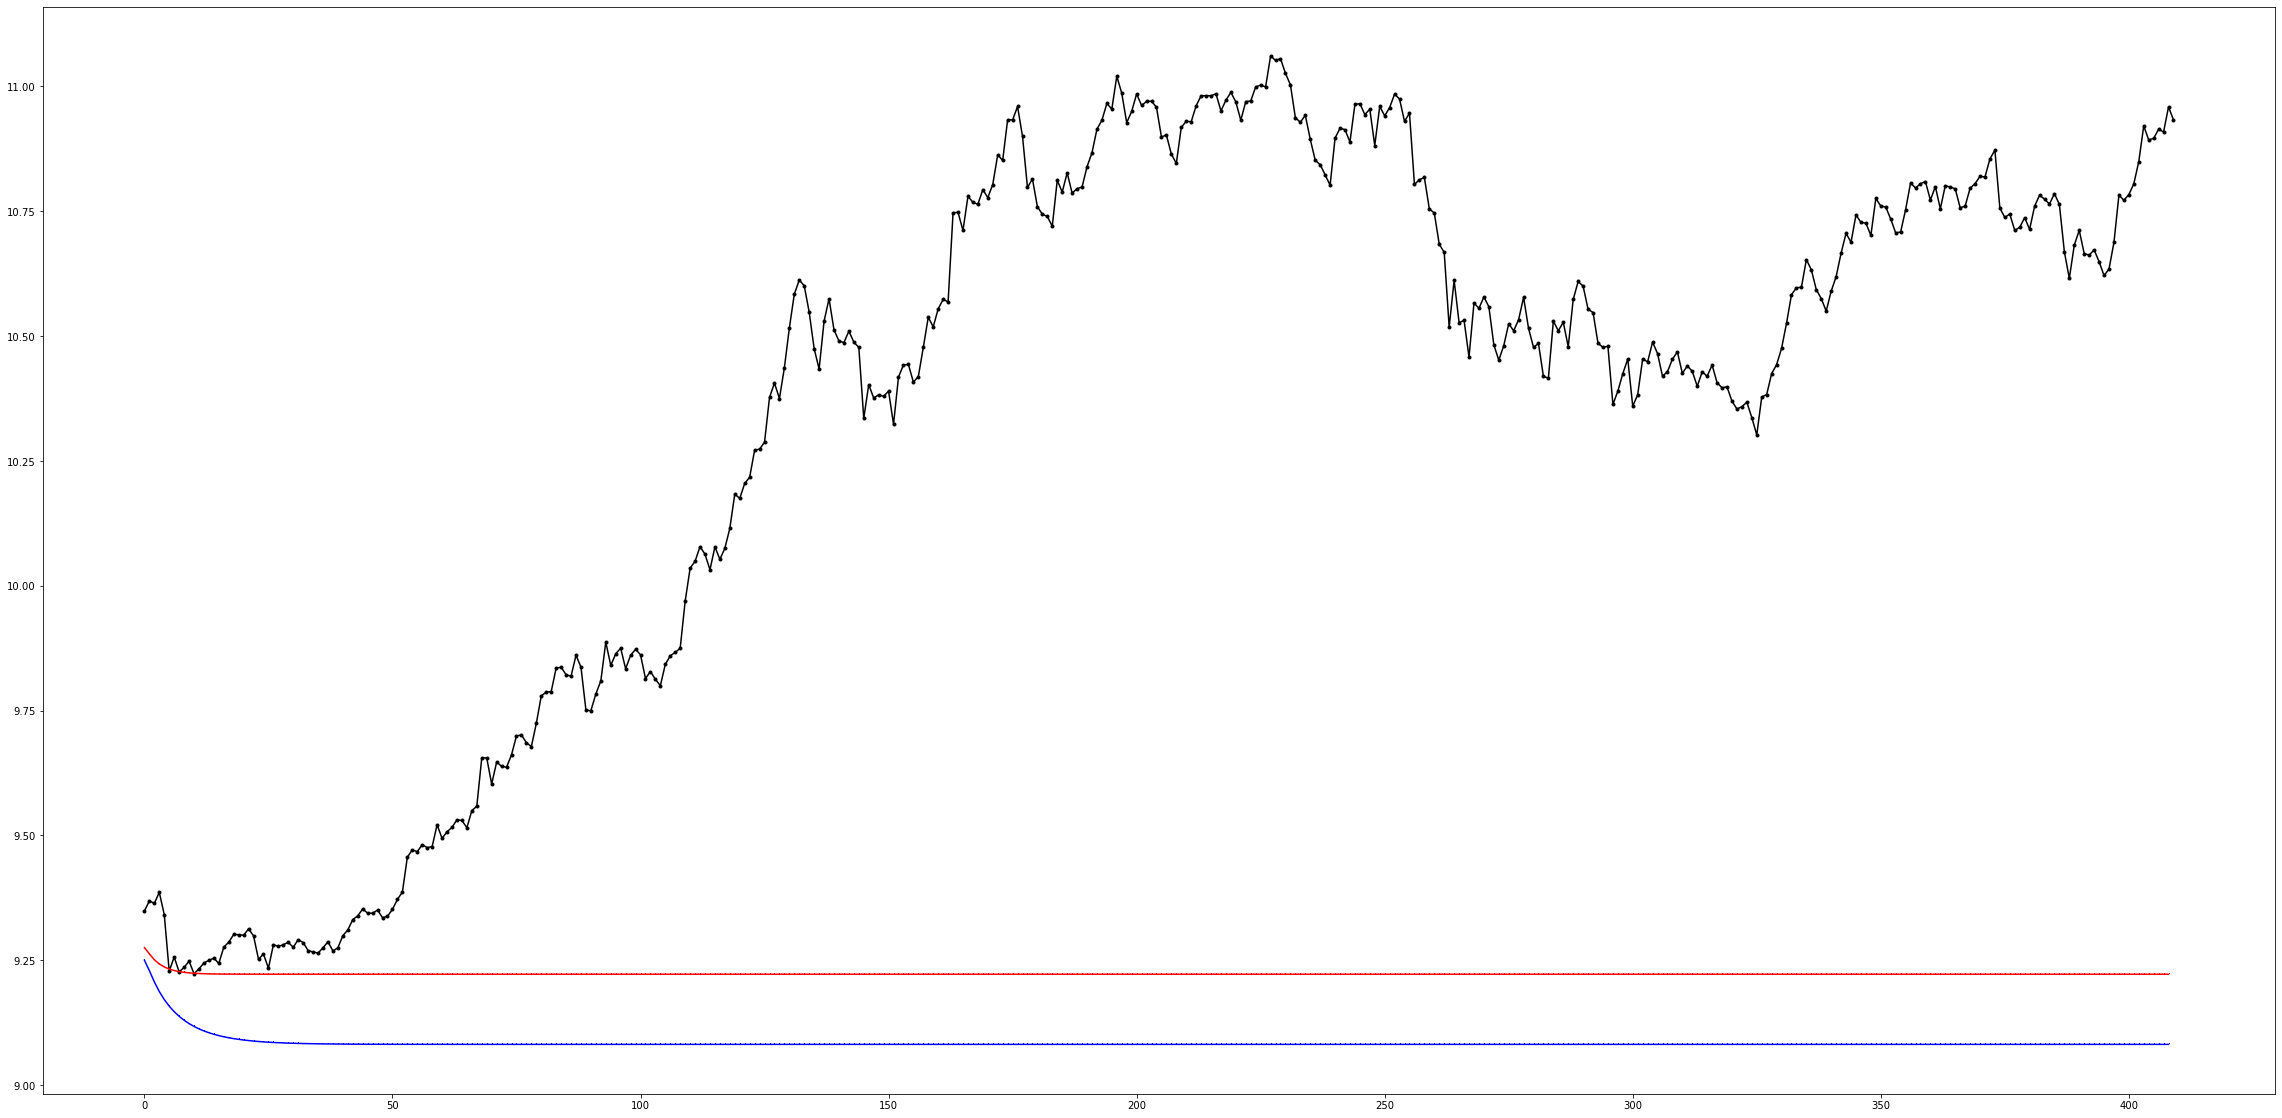

In [60]:

#compare rnn and lstm prediction result with real
plt.figure(figsize=(40,20))
plt.plot(np.append(train, test)[int((ratioOfFit)*len(df)):], marker='.', label='real',  color='black')
plt.plot(predict_rnn[int(ratioOfFit*len(df)):], marker=',', label='RNN',  color='red')
plt.plot(predict_lstm[int(ratioOfFit*len(df))::], marker=',', label='LSTM',  color='blue')
plt.show()
